# Shreyank Shetty (12279686)
## FINM 33150 1 Regression Analysis and Quantitative Trading Strategies
### Homework: FX Carry Strategy 




In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quandl
import warnings
import functools
import statsmodels.api as sm
import datetime as dt
import os
from scipy.stats import describe
from scipy.stats import norm
from datetime import datetime, timedelta
from matplotlib import cm
from scipy.stats import zscore
import seaborn as sns
plt.rcParams["figure.figsize"] = (16,15)
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

### Fetching Data From Quandl

In [52]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_securities):
        print("Fetching from Quandl")
        qdata = quandl.get(list(my_securities), returns="pandas",
                          api_key=os.getenv('QuandlKey'),
                          start_date='2015-01-01', end_date='2021-12-15')
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl already defined


Extracting Yeild curves for GBP,PHL,THA,PAK,ZAF and IND and then resampling  and forward filling them to have weekly frequecy starting every wednesday in the data range.

Date Range: 2015-01-01 : 2021-12-15

In [53]:
gbr = fetch_quandl(tuple(['YC/GBR5Y']))
gbr.columns = [5]
gbr = gbr.interpolate(axis = 0, method = 'index').resample('W-Wed').asfreq().fillna(method='ffill')/100

phl = fetch_quandl(('YC/PHL1Y','YC/PHL2Y','YC/PHL3Y','YC/PHL4Y','YC/PHL5Y'))
phl.columns = [1,2,3,4,5]
phl = phl.interpolate(axis = 0, method = 'index').resample('W-Wed').asfreq().fillna(method='ffill')/100

tha = fetch_quandl(('YC/THA1Y','YC/THA2Y','YC/THA3Y','YC/THA4Y','YC/THA5Y'))
tha.columns = [1,2,3,4,5]
tha = tha.interpolate(axis = 0, method = 'index').resample('W-Wed').asfreq().fillna(method='ffill')/100

pak = fetch_quandl(('YC/PAK3Y','YC/PAK5Y','YC/PAK10Y'))
pak.columns = [3,5,10]
pak = pak.interpolate(axis = 0, method = 'index').resample('W-Wed').asfreq().fillna(method='ffill')/100

zaf = fetch_quandl(('YC/ZAF12M','YC/ZAF10Y'))
zaf.columns = [1,10]
zaf = zaf.interpolate(axis = 0, method = 'index').resample('W-Wed').asfreq().fillna(method='ffill')/100
zaf[5] = (zaf[1]+zaf[10])/2
zaf.sort_index(axis=1, inplace=True)

ind = fetch_quandl(('YC/IND2Y','YC/IND5Y','YC/IND10Y'))
ind.columns = [2,5,10]
ind = ind.interpolate(axis = 0, method = 'index').resample('W-Wed').asfreq().fillna(method='ffill')/100

### Exploring the Data

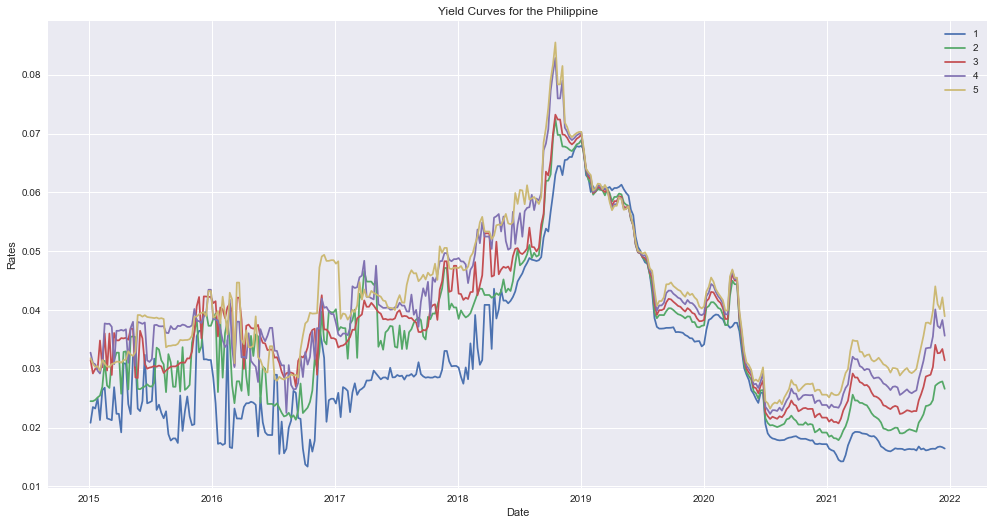

In [72]:
plt.figure(figsize=(15,8))
plt.plot(phl)
plt.title('Yield Curves for the Philippine')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend(phl.columns)

### Inverted yield curve for the Pakistan Government Bonds

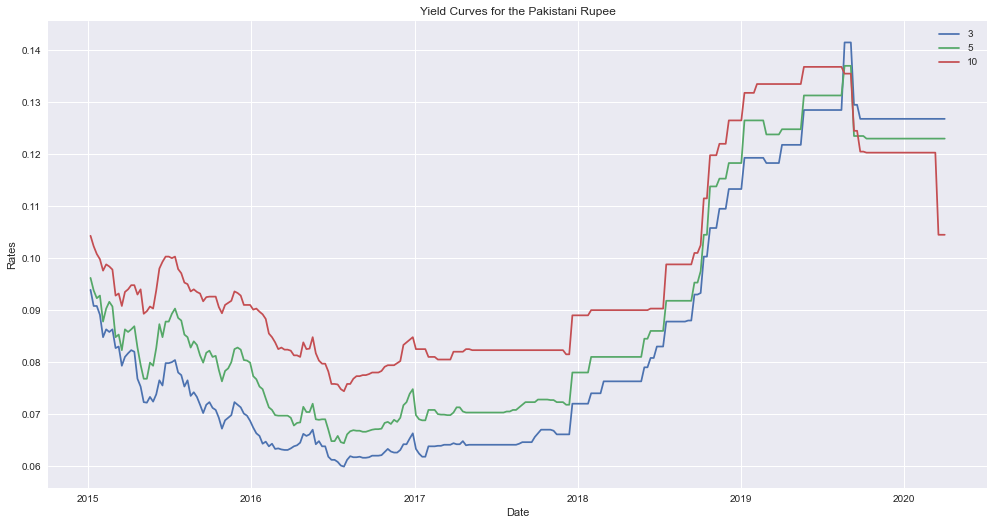

In [73]:
plt.figure(figsize=(15,8))
plt.plot(pak)
plt.title('Yield Curves for the Pakistani Rupee')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend(pak.columns)

It is interesting to note that the yeild curve is inverted for the pakistani government bonds. This implies that the long term bonds are priced lower than than short term bonds as evident from the above graph. This is a sign of a potenial future recession in the economy. 

#### Fetching the FX rates for these currencies 

In [56]:
fx = fetch_quandl(tuple(['CUR/GBP','CUR/PHP','CUR/PKR','CUR/THB','CUR/ZAR', 'CUR/INR']))
fx.columns = fx.columns.str.split(' - ').str[0]
fx.columns = fx.columns.str.replace('CUR','USD')
fx = fx.resample('W-Wed').asfreq()
fx.head()

,USD/GBP,USD/PHP,USD/PKR,USD/THB,USD/ZAR,USD/INR
DATE,,,,,,
2015-01-07,0.661818,45.07233,100.848890,32.87127,11.68697,63.29091
2015-01-14,0.656415,44.68150,100.587020,32.78778,11.45532,62.13565
2015-01-21,0.660404,44.43083,100.688550,32.59503,11.54359,61.62410
2015-01-28,0.660470,44.12199,100.904621,32.56594,11.56527,61.34769
2015-02-04,0.658823,44.09932,101.248501,32.61864,11.47746,61.78422


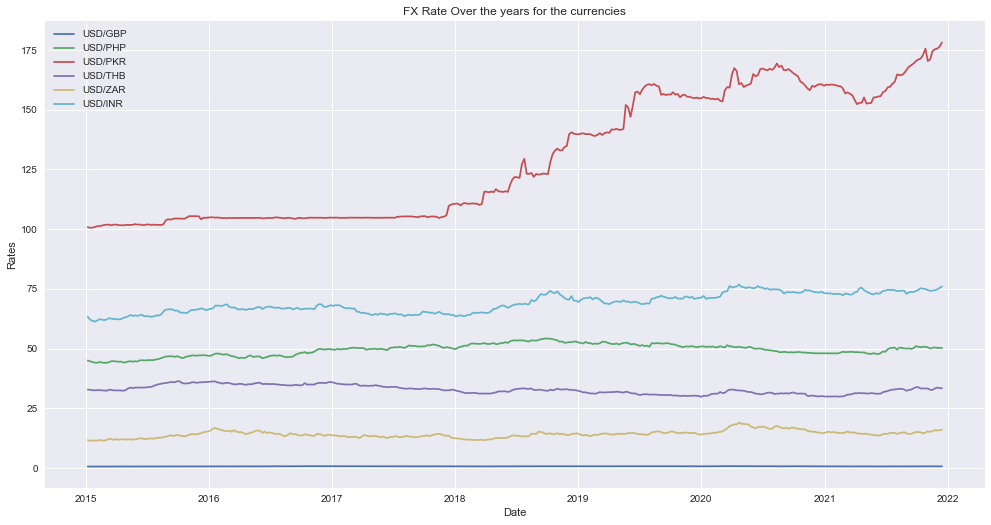

In [74]:
plt.figure(figsize=(15,8))
plt.plot(fx)
plt.title('FX Rate Over the years for the currencies')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend(fx.columns)

We can make few interesting obeservations here. A carry trade on the pakistan rupee is most suspectible to currency depriciation and hence, errosion of profits. 

Also note that the USD/GBP is almost a straight line, implying the how steady the currency is. 

#### Fetching 1M rates for UK Overnight Index Swaps 

In [58]:
gbpois = fetch_quandl(tuple(['YC/GBR_ISSC']))
gbpois = gbpois.filter(regex= '0.08Y').resample('W-Wed').asfreq().fillna(method='ffill')/100
gbpois = gbpois.rename(columns ={'YC/GBR_ISSC - 0.08Y':'GBPOIS'})
gbpois.head()

,GBPOIS
Date,
2015-01-07,0.004328
2015-01-14,0.004322
2015-01-21,0.004330
2015-01-28,0.004345
2015-02-04,0.004402


#### Getting the Zero Coupon Bond Curve 

In [59]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon))/tenor
    return zcb_rates

In [60]:
zcb_gbr= compute_zcb_curve(gbr.T)
zcb_phl= compute_zcb_curve(phl.T)
zcb_tha= compute_zcb_curve(tha.T)
zcb_pak= compute_zcb_curve(pak.T)
zcb_zaf= compute_zcb_curve(zaf.T)

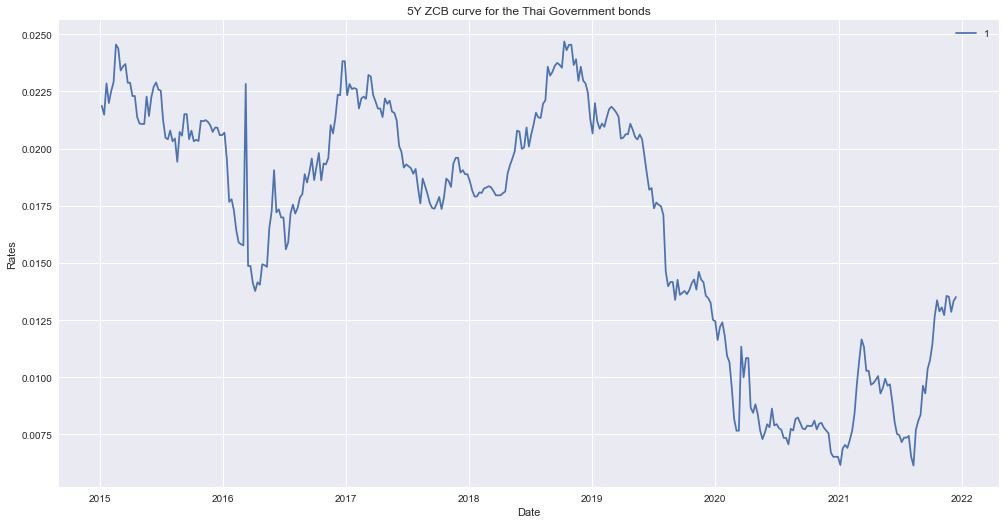

In [75]:
plt.figure(figsize=(15,8))
plt.plot(zcb_tha.T[5])
plt.title('5Y ZCB curve for the Thai Government bonds')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend(zcb_tha.T.columns)

## Strategy 

In [132]:
# Function to price the bond
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor-1/52, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb['rate'].values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p

# Holding based approach to backtest our strategy
def backtest(zcb_cur,curnc,fx,fx_pair):
    """ Backtest the FX carry strategy by borrowing in GBP OIS and lending in the currency provided.
    The bond is held for one week, and the Marked to Market. Next week the notional is reset to 10 and trading
    takes places.
    
    
    :param zcb_curr: Zero coupon curve for the lending currency
    :param curnc: lending currency
    :param fx: Fx rates datframe
    :param fx_par: Indicates the column to be used in fx df. #TBD incorporate into single param. 
    

    """
    
    df = pd.DataFrame(index = zcb_cur.T.index, columns=['pnl','ret','bond'])
    for index, row in zcb_cur.T[1:].iterrows():  
        notional= 1e7
        leverage=0.8
        
        prev_index= index-pd.DateOffset(days=7)
        interest= (gbpois.loc[prev_index]['GBPOIS']+ 0.5*1/100)*leverage*notional*(1/52)
        # Only trade if it matches below filter
        if gbpois.loc[prev_index]['GBPOIS']+ 0.5*1/100 < curnc.loc[prev_index][5]:

            frx= notional*fx.loc[prev_index][fx_pair]
            coupon= curnc.loc[prev_index][5]
            lend_amount= frx

            #price the bond (current week)
            p= bond_price(row.to_frame('rate'), coupon, tenor=5)
            lend_reciev= p*frx
            # profit/losse from holding the bond
            delta= lend_reciev - lend_amount
            delta_usd= delta/fx.loc[index][fx_pair] #convert to usd 
            pnl = delta_usd - (interest)
            ret = pnl/((1-leverage)*notional) # calculate returns on only 2 million of USD equity
        else:
            pnl=0
            ret=0
            p=0

        df.loc[index]['pnl']= pnl
        df.loc[index]['ret'] = ret
        df.loc[index]['bond'] = p
    return df
    

In [77]:
tha_ret=backtest(zcb_tha,tha,fx,'USD/THB')
phl_ret=backtest(zcb_phl,phl,fx,'USD/PHP')
zaf_ret=backtest(zcb_zaf,zaf,fx,'USD/ZAR')
pak_ret=backtest(zcb_pak,pak,fx,'USD/PKR')

#### Analysis of Returns

In [85]:
# Performance_metrics
def return_stats(returns, annualization=1):
    stats = pd.DataFrame(index=returns.columns)
    stats['mean'] = returns.mean() * annualization
    stats['vol'] = returns.std() * np.sqrt(annualization)
    stats['Sharpe'] = stats['mean'] / stats['vol']

    stats['min'] = returns.min()
    stats['max'] = returns.max()

    return stats

# Tail risk stats
def max_drawdown(returns):
    
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    
    # date of bottom
    min_date = drawdown.idxmin()
    min_level = cum_returns.loc[min_date]
    
    # date of previous max
    max_date = cum_returns.loc[cum_returns.index <= min_date].idxmax()
    max_level = cum_returns.loc[max_date]
    
    try:
        recovery_date = cum_returns.loc[cum_returns.index > min_date][cum_returns >= max_level].index[0] # first time it is greater
    except:
        recovery_date = None
    
    return (min_level - max_level)/max_level, max_date, min_date, recovery_date

def tail_risk_stats(returns):
    stats = pd.DataFrame(index=returns.columns)
    stats['Skewness'] = returns.skew()
    stats['Excess Kurtosis'] = returns.kurtosis() - 3
    stats['VaR 0.05'] = returns.quantile(0.05)
    stats['CVaR 0.05'] = returns[returns <= returns.quantile(0.05)].mean()
    
    for fund in stats.index:
        stats.loc[fund, ['Max Drawdown', 'Peak', 'Bottom', 'Recover']] = max_drawdown(returns[fund])
        
    return stats

# Correlations of Returns
def display_corr(df, print_maxmin=True):
    
    corr = df.corr()
    corr[corr==1] = None
    plt.figure(figsize = (15,8))
    sns.heatmap(corr, annot=True)

    if print_maxmin:
        corr_rank = corr.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')
        
    return corr

In [86]:
def return_plots(returns, title, pnl, spot):
    """using a time series of returns, the function plots the time series of the returns
        with a line for the mean, mean+1std, mean-1std, and the histogram with a fitted normal distribution
        
    :param returns: a time series dataframe of returns of securities
    :param title: a title for the graphs

    """
    
    mean = returns.mean()
    vol = returns.std()
    median = np.median(returns)
    
    fig, axs = plt.subplots(2, 2, figsize=(30, 10))
    
    #plot 1
    axs[0][0].plot(returns)
    axs[0][0].axhline(mean, c='r')
    axs[0][0].axhline(mean+vol, c='r')
    axs[0][0].axhline(mean-vol,c='r')
    axs[0][0].set_title('{} Returns'.format(title), size=15)
    axs[0][0].set_xlabel('Date', size=12)
    axs[0][0].set_ylabel('Return', size=12)
    textstr = '\n'.join((
            r'$\mu=%.4f$' % (mean*100, ),
            r'$\mathrm{median}=%.4f$' % (median*100, ),
            r'$\sigma=%.4f$' % (vol*100, )))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[0][0].text(0.05, 0.95, textstr, transform=axs[0][0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    #plot 2
    axs[0][1].hist(returns, bins=50, density=True)
    axs[0][1].axvline(mean, c='r')
    axs[0][1].axvline(mean+vol, c='r')
    axs[0][1].axvline(mean-vol,c='r')
    axs[0][1].set_title('{} Return Distribution'.format(title), size=15)
    axs[0][1].set_xlabel('Return', size=12)
    axs[0][1].set_ylabel('Density', size=12)
    
    x = np.linspace(-0.15, 0.15, 100)
    p = norm.pdf(x, mean, vol)
  
    axs[0][1].plot(x, p, 'k', linewidth=2)
    
    #plot 3
    axs[1][0].plot((1+returns).cumprod())
    axs[1][0].set_title('{} Cummulative Returns'.format(title), size=15)
    axs[1][0].set_xlabel('Return')
    axs[1][0].set_ylabel('Date')
    
    #plot 4
    #axs[1][1].plot(returns)
    axs[1][1].plot(spot)
    axs[1][1].set_title('Spot Yield Curve ', size=15)
    axs[1][1].set_xlabel('Date')
    axs[1][1].set_ylabel('Rate')
    

### Analysis of the the Strategy on the currency pairs 

In [91]:
all_ret= pd.concat([tha_ret['ret'],phl_ret['ret'],pak_ret['ret'],zaf_ret['ret']],axis=1)
all_ret.columns= ["THA","PHL", "PAK", "ZAF"]
all_ret

,THA,PHL,PAK,ZAF
Date,,,,
2015-01-07,NaN,NaN,NaN,NaN
2015-01-14,0.008803,0.021872,0.051741,0.043054
2015-01-21,-0.032576,0.012331,0.03361,0.039808
2015-01-28,0.018862,-0.002791,-0.006232,0.035829
2015-02-04,-0.0127,0.017761,0.103906,-0.006882
...,...,...,...,...
2021-11-17,-0.019028,-0.093169,NaN,NaN
2021-11-24,0.001939,0.070995,NaN,NaN
2021-12-01,0.016265,0.020891,NaN,NaN


#### Cummulative Returns

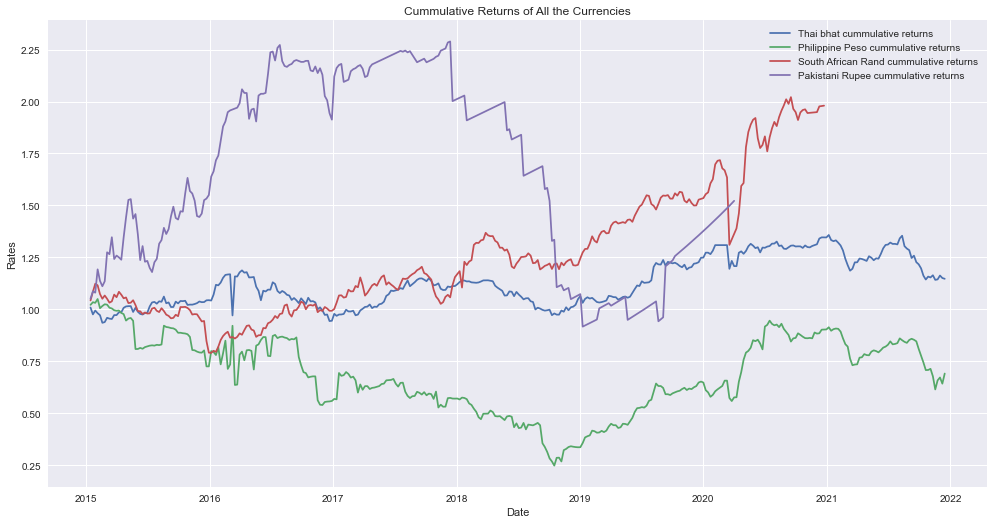

In [81]:
plt.figure(figsize=(15,8))
plt.plot((1+tha_ret['ret']).cumprod(), label='Thai bhat cummulative returns')
plt.plot((1+phl_ret['ret']).cumprod(), label='Philippine Peso cummulative returns')
plt.plot((1+zaf_ret['ret']).cumprod(), label='South African Rand cummulative returns')
plt.plot((1+pak_ret['ret']).cumprod(), label='Pakistani Rupee cummulative returns')
plt.title('Cummulative Returns of All the Currencies')
plt.xlabel('Date')
plt.ylabel('Rates')
plt.legend()
#plt.legend(zcb_tha.T.columns)

We see from the above graph that South African Rand was the best performing asset followed by the pakistani rupee, which had a lot of volatility in returns, this can be attributed to the fall in the currency value and the increase in the yield curve for the soverign bonds of pakistan. The worst performer was the philppine peso, which made losses. 

#### Return Statistics 

In [94]:
ret_stats = return_stats(all_ret, annualization=52)
ret_stats

,mean,vol,Sharpe,min,max
THA,0.030310,0.145693,0.208037,-0.169502,0.193416
PHL,0.013090,0.361733,0.036186,-0.309149,0.253331
PAK,0.114201,0.261573,0.436594,-0.171026,0.255271
ZAF,0.131124,0.181028,0.724330,-0.19845,0.112377


We can note from the return statistics that this strategy performes poorly for thailand and philippines. The returns are pretty bad here and the sharpe isnt good either. 

South Africa and Pakistan have done well in our backetesting. South African rand has a very good sharpe ratio and mean returns. 

### Analysis of Thai Bhat 

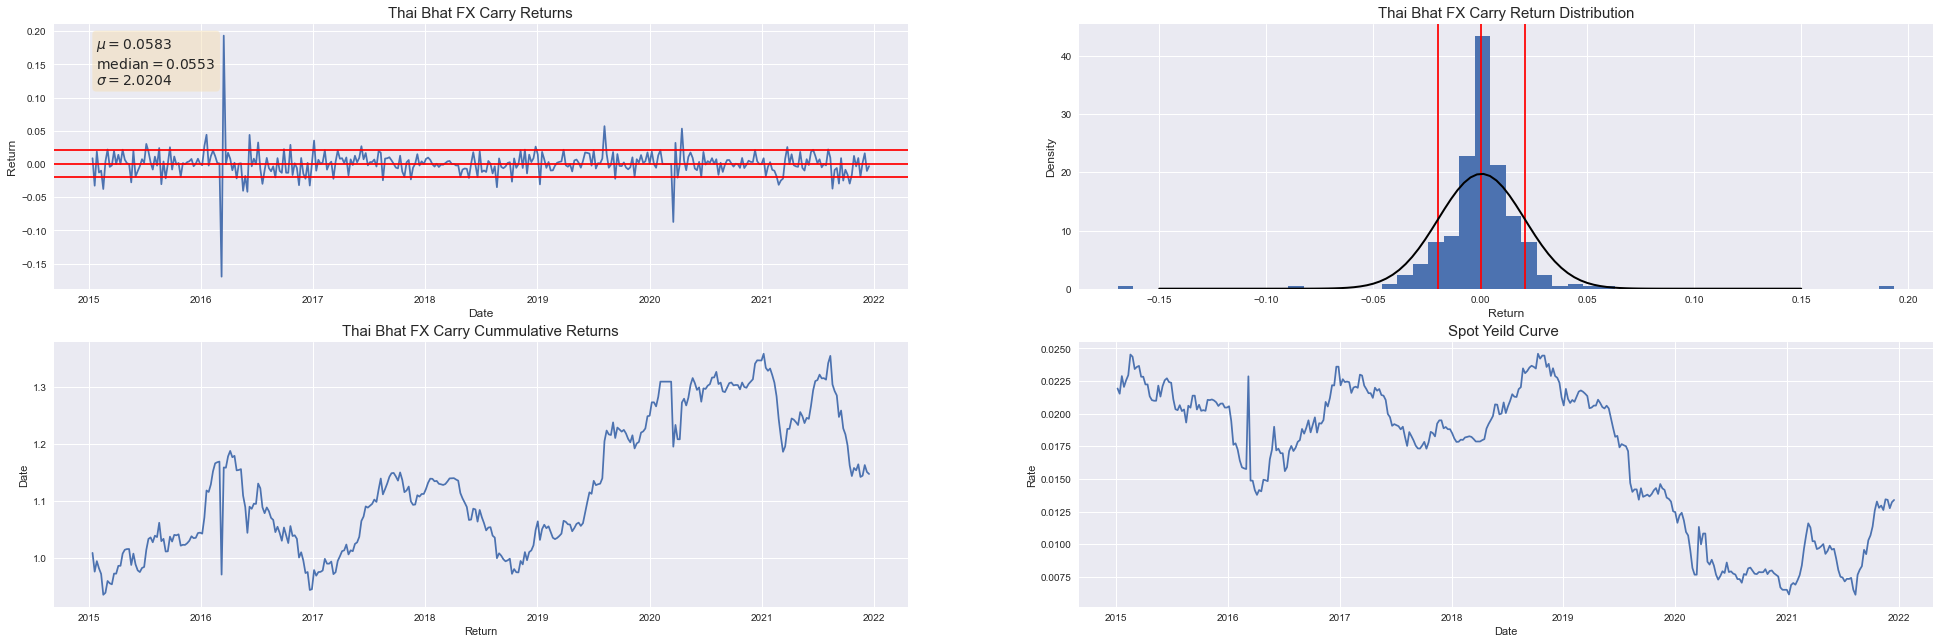

In [66]:
return_plots(tha_ret['ret'],'Thai Bhat FX Carry', tha_ret['pnl'], tha[5])

##### Risk Statistics

In [107]:
risk_stats = tail_risk_stats(tha_ret['ret'].dropna().astype(float).to_frame())
risk_stats

,Skewness,Excess Kurtosis,VaR 0.05,CVaR 0.05,Max Drawdown,Peak,Bottom,Recover
ret,0.568421,33.607441,-0.024859,-0.042337,-0.205358,2016-04-06 00:00:00,2016-12-21 00:00:00,2019-08-07 00:00:00


MIN Correlation pair is ('ret', 5)
MAX Correlation pair is (5, 'ret')


,ret,5
ret,NaN,-0.052667
5,-0.052667,NaN


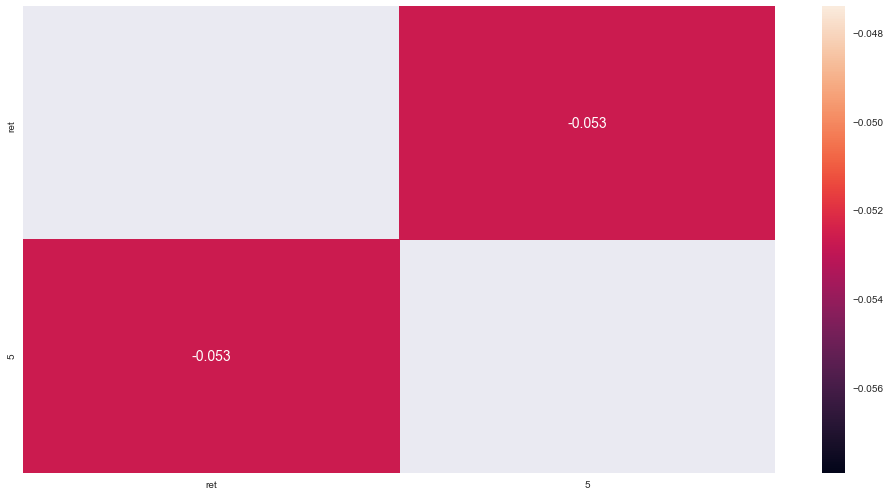

In [130]:
corr_df= pd.merge(tha_ret['ret'].astype(float).to_frame(), tha[5].to_frame(), left_index=True, right_index=True)
corr = display_corr(corr_df)
corr

We find that the correlation of our strategy with the yield curve is almost negligible. 

### Analysis of South African Rand 

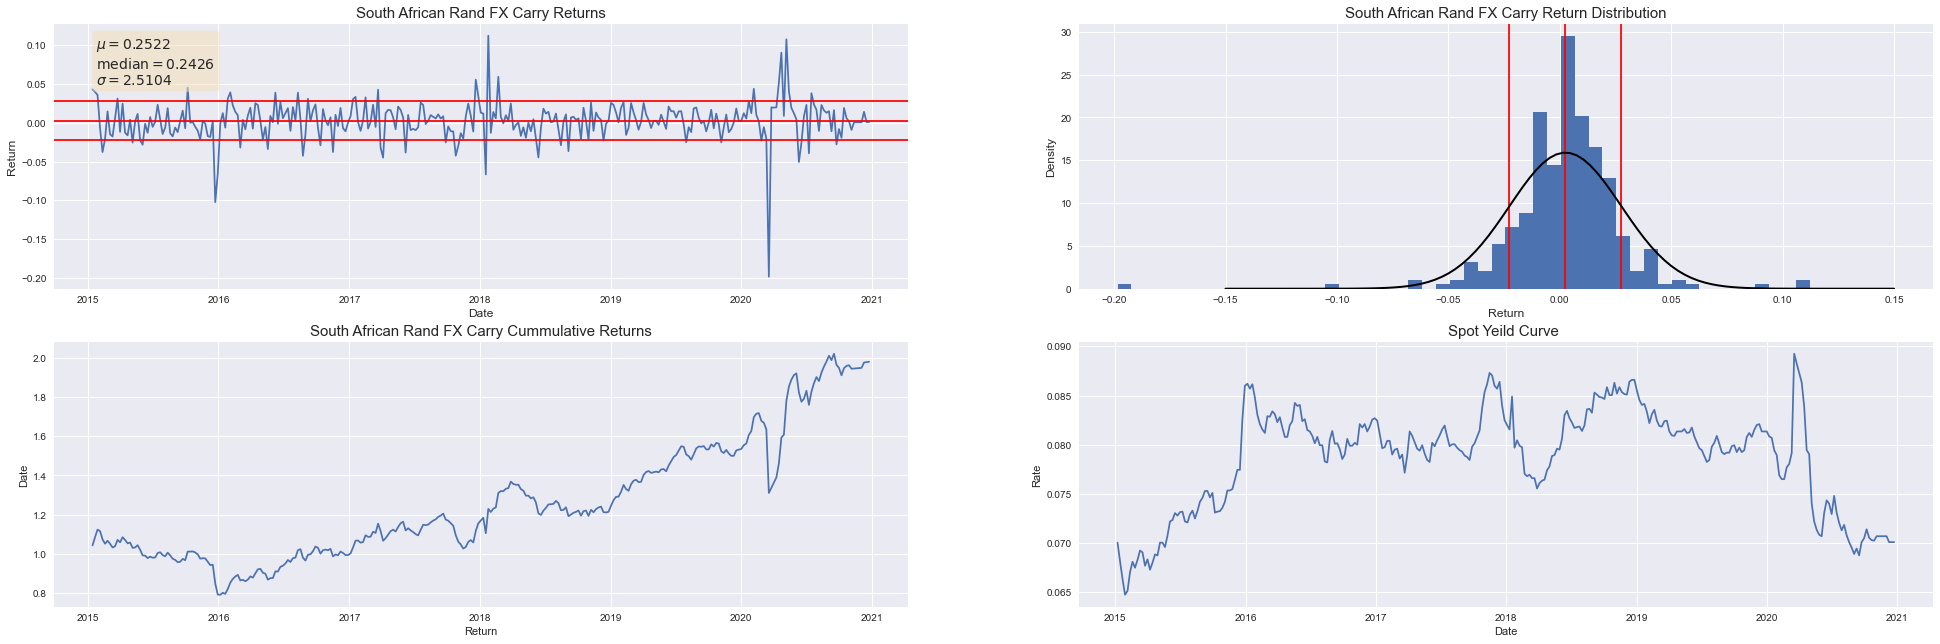

In [82]:
return_plots(zaf_ret['ret'],'South African Rand FX Carry', zaf_ret['pnl'], zaf[5])

##### Risk Statistics 

In [108]:
risk_stats = tail_risk_stats(zaf_ret['ret'].dropna().astype(float).to_frame())
risk_stats

,Skewness,Excess Kurtosis,VaR 0.05,CVaR 0.05,Max Drawdown,Peak,Bottom,Recover
ret,-1.379176,12.560008,-0.032109,-0.057161,-0.296073,2015-01-28 00:00:00,2016-01-06 00:00:00,2017-03-22 00:00:00


### Analysis of Pakistani Rupee

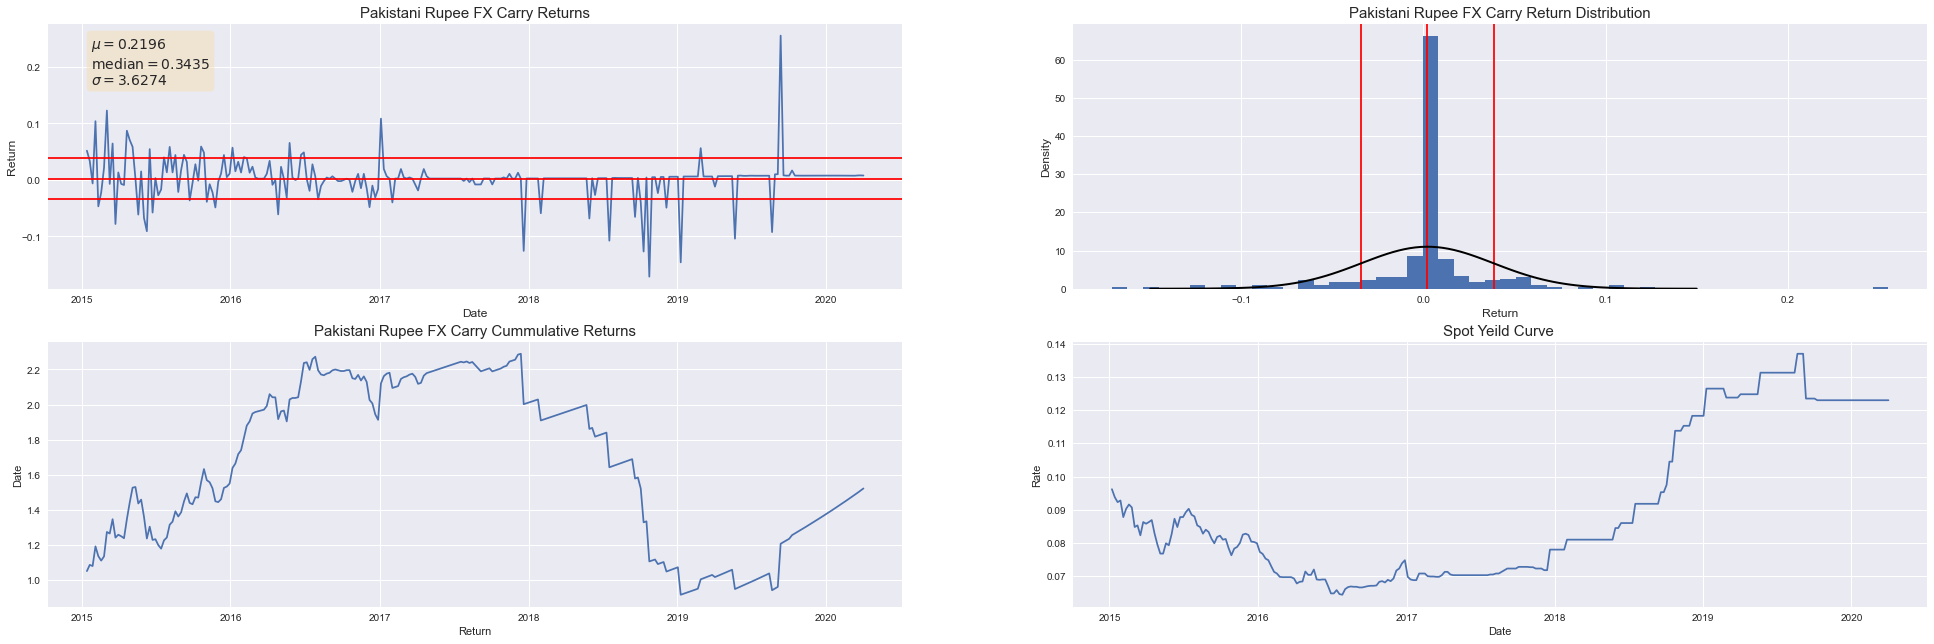

In [83]:
return_plots(pak_ret['ret'],'Pakistani Rupee FX Carry', pak_ret['pnl'], pak[5])

We can see from the above graphs that as the yield curve drops our returns increase and as the yeild increases our returns drop.

##### Risk Statistics 

In [109]:
risk_stats = tail_risk_stats(pak_ret['ret'].dropna().astype(float).to_frame())
risk_stats

,Skewness,Excess Kurtosis,VaR 0.05,CVaR 0.05,Max Drawdown,Peak,Bottom,Recover
ret,0.256884,9.824982,-0.059713,-0.097405,-0.599395,2017-12-13 00:00:00,2019-01-09 00:00:00,NaN


### Analysis of Philippine Peso

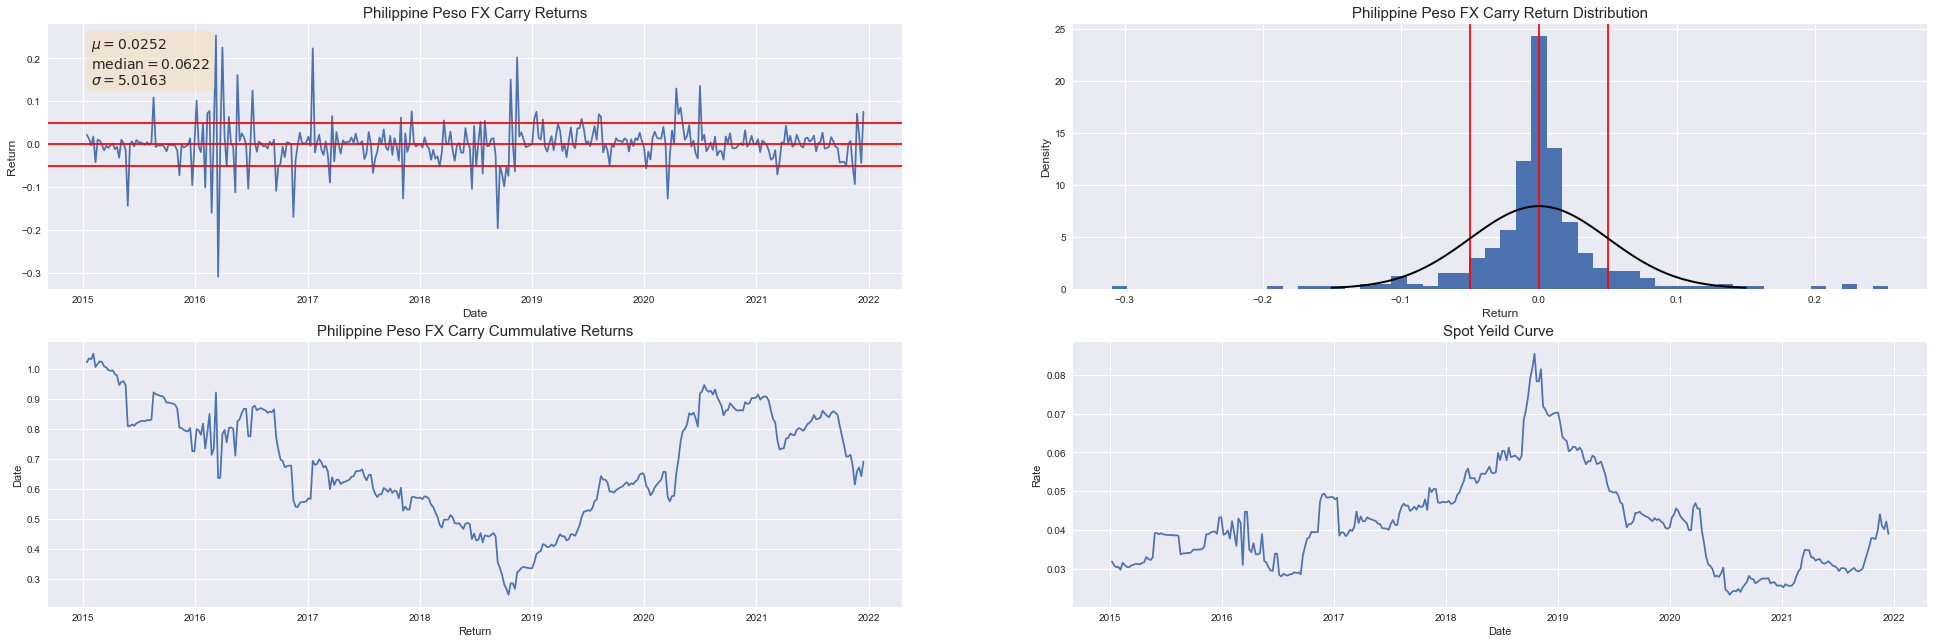

In [84]:
return_plots(phl_ret['ret'],'Philippine Peso FX Carry', phl_ret['pnl'], phl[5])

##### Risk Statistics 

In [110]:
risk_stats = tail_risk_stats(phl_ret['ret'].dropna().astype(float).to_frame())
risk_stats

,Skewness,Excess Kurtosis,VaR 0.05,CVaR 0.05,Max Drawdown,Peak,Bottom,Recover
ret,0.067605,6.418986,-0.070751,-0.124061,-0.76336,2015-02-04 00:00:00,2018-10-17 00:00:00,NaN


### Correlations of the returns 

MIN Correlation pair is ('THA', 'PHL')
MAX Correlation pair is ('ZAF', 'THA')


,THA,PHL,PAK,ZAF
THA,NaN,-0.219034,0.100061,0.197911
PHL,-0.219034,NaN,-0.065072,0.158109
PAK,0.100061,-0.065072,NaN,-0.019622
ZAF,0.197911,0.158109,-0.019622,NaN


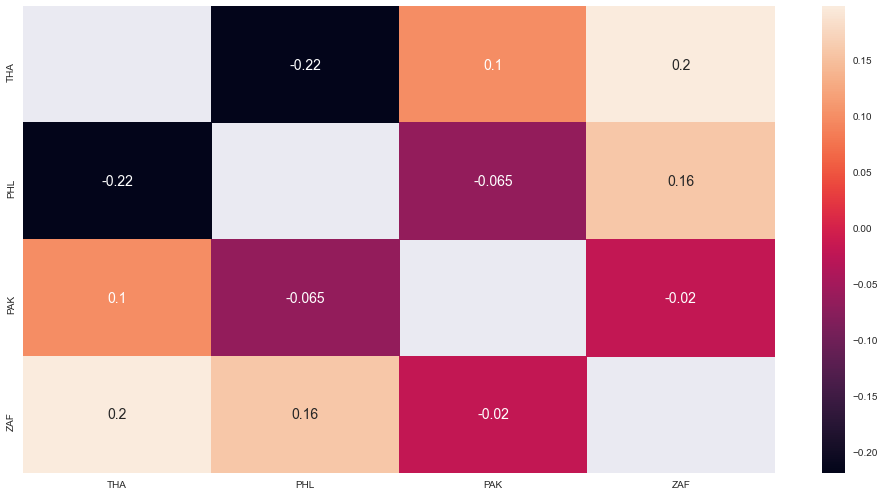

In [115]:
corr = display_corr(all_ret.dropna().astype(float))
corr

## Fama French Factor Analysis 

In [116]:
# Regression ratio stats with a benchmark
def regression_stats(returns, market_return, annualization=1):
    
    stats = pd.DataFrame(index=returns.columns)
    
    X = sm.add_constant(market_return) # add a const to X data
    
    for fund in stats.index:
        y = returns[fund]
        results = sm.OLS(y, X, missing='drop').fit()
        alpha = results.params[0]
        beta = results.params[1]
        stats.loc[fund, 'Alpha'] = alpha * annualization
        stats.loc[fund, 'Market Beta'] = beta
        stats.loc[fund, 'Treynor Ratio'] = (y.mean() / beta) * annualization
        stats.loc[fund, 'Information Ratio'] = (alpha / results.resid.std()) * np.sqrt(annualization)
    
    return stats

# Regression statistics with the Fama French factors
def FF_regression(returns, factors, annualization=12):
    X = sm.add_constant(factors)
    
    stats = []
    
    for fund in returns.columns:
        y = returns[fund]
        results = sm.OLS(y, X, missing='drop').fit()
        params = results.params.to_frame(fund).T
        stats.append(params)
        params['r-squared'] = results.rsquared
        
    return pd.concat(stats)

In [119]:
# Import the Fama French factors
FF_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows = 3)
FF_df.dropna(inplace=True)
FF_df.rename(columns={'Unnamed: 0':'date'}, inplace=True)

FF_df['date'] = pd.to_datetime(FF_df['date'], format='%Y%m%d')
FF_df.set_index('date', inplace = True)
FF_df.sort_index(inplace=True)

FF_df = FF_df.loc[FF_df.index.isin(all_ret.index)] 
FF_df = FF_df / 100
FF_cum_ret = (1+FF_df).cumprod()

Text(0, 0.5, 'Cumulative Return')

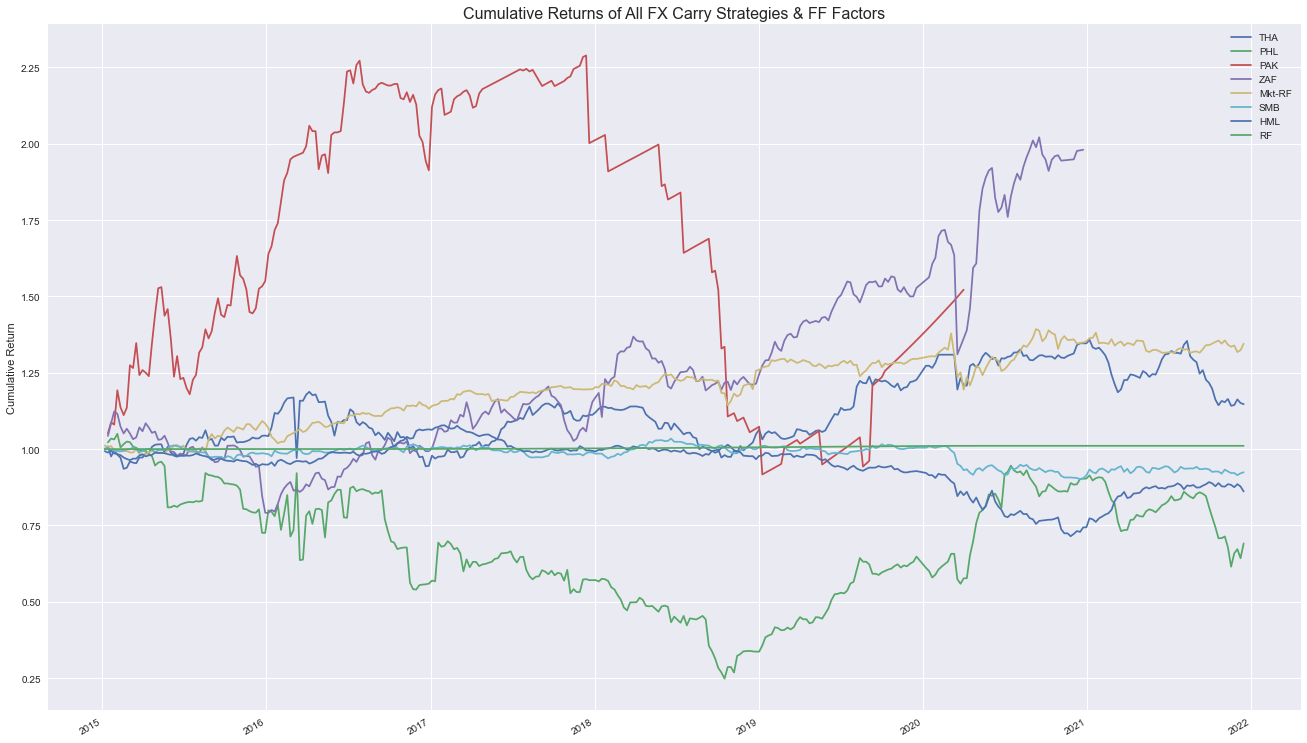

In [131]:
all_strat_cum_ret = (1+all_ret).cumprod()
pd.merge(all_strat_cum_ret, FF_cum_ret, left_index=True, right_index=True).plot(figsize=(20, 14))
plt.title('Cumulative Returns of All FX Carry Strategies & FF Factors', size=16)
plt.ylabel('Cumulative Return')

By plotting the returns for all the currencies and the fame french factos, we see that our stratgey is more volatile than the fama french factors. 
Currency such a pakistan rupee and Philippine Peso is highly volatile.

We are however able to provide higher returns than than Fame French factors for some of the Currency pairs. 

In [126]:
reg_df= all_ret.loc[all_ret.index.isin(FF_df.index)] 
FF_reg = FF_regression(reg_df.astype(float), FF_df[['Mkt-RF', 'SMB', 'HML']], annualization=52)
FF_reg

,const,Mkt-RF,SMB,HML,r-squared
THA,0.000525,0.015897,0.108101,-0.044970,0.001476
PHL,0.000378,-0.044777,-0.054253,-0.036538,0.000265
PAK,0.001809,0.332034,0.660254,-0.851936,0.040832
ZAF,0.002567,0.273374,0.348525,0.270010,0.044792


By running a regression of our strategy returns with the Fama French factors, we can see that it is difficult to replicate/explain most of our returns using just these factors. Most of the factor coefficients are small alongside the r-squared. The strategy with the highest r-squared is the ZAF pair, which seems to be explained by SMB and HML. Most of our strategies have a slight alpha, meaning they will perform better than trying to replicate it with the 3 factors.

In [128]:
market_reg = regression_stats(reg_df.astype(float), FF_df['Mkt-RF'], annualization=52)
market_reg

,Alpha,Market Beta,Treynor Ratio,Information Ratio
THA,0.026195,0.033051,0.837071,0.179209
PHL,0.021388,-0.056075,-0.336922,0.058891
PAK,0.108437,0.382113,0.318772,0.415615
ZAF,0.111105,0.350771,0.368779,0.617542


From the regression against the market benchmark, a majority of our strategies have a very low market beta and a decent alpha.Pak seems top have a higher beta amoong our currency pairs. Therefore, these strategies were able to deliver returns that are unexplained by the market. Our Treynor Ratio and Information Ratio for all the strategies are mediocore, making them slightly unattractive. However, their low correlation with the market offers good diversification benefits.

In [129]:
combined_FF = pd.merge(reg_df.astype(float), FF_df, left_index=True, right_index=True)
FF_corr = combined_FF.corr()
FF_corr[['Mkt-RF', 'SMB', 'HML']]

,Mkt-RF,SMB,HML
THA,0.017787,0.031581,-0.010588
PHL,-0.012148,-0.011844,-0.009320
PAK,0.110800,0.107644,-0.125256
ZAF,0.156733,0.151018,0.136304
Mkt-RF,1.000000,0.296388,0.050822
SMB,0.296388,1.000000,0.280520
HML,0.050822,0.280520,1.000000
RF,-0.010686,-0.008953,-0.056396


Our correlation with the market, SMB, and HML factors all remain quite low. Our highest correlation is our PAK Strategy at 0.15 with market, 0.15 for SMB, and 0.13 HML. As this is our best performing strategy, it can be expected to have a higher correlation with these factors. For the other strategies, our returns did not depend on having a lot of exposure to long the market or any of the other factors, so the resulting correlation is low. Which is expected since these strategy should not have much correlation with the equity markets. 

## Conclusions

- This strategy is highly volatile for few currency pairs as evident by the graphs, showing large swings for a particular timeframes 
- It is very important to note that this strategy has a lot of tail risk associcated with it. Although we did not see this within our time frame
- The stratgey provides good diverification benefits, as its not correlatted with F-F factors.
- It would be interesting to see the performance of this strategy on different currencies pairs and a large data set. 
- The data available on quandl was not really good to completely trust this backtesting results. 
- TBD: Run the swiss franc on this strategy, since it had a famous tail risk event associated with it. 